In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, lognorm

### Sources

In [2]:
# https://math.stackexchange.com/questions/3472542/calculating-expectation-and-variance-of-s-t-stochastic-differential-equation
# https://en.wikipedia.org/wiki/Log-normal_distribution


### Geometric Brownian Motion simulation with stochastic process modeling

In [2]:
trading_days_in_year = 252
T = 1.0
steps = int(T * trading_days_in_year)
path_count = 2**15
s0 = 100
r = 0.1
sigma = 0.2


In [3]:
dt = T / steps
shocks = np.random.normal(0, 1, (path_count, steps))
paths = np.zeros((path_count, steps + 1))
paths[:, 0] = s0
for i in range(1, steps + 1):
    paths[:, i] = paths[:, i - 1] + paths[:, i - 1] * r * dt + sigma * paths[:, i - 1] * np.sqrt(dt) * shocks[:, i - 1]


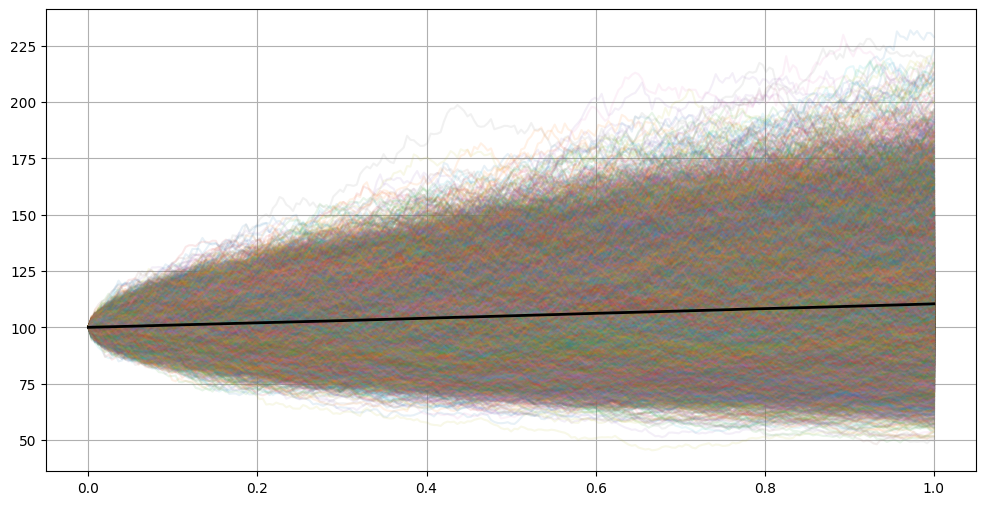

In [4]:
x_axis = np.linspace(0, T, steps + 1)
plt.figure(figsize=(12, 6))
plt.plot(x_axis, paths.T, alpha=0.1)
plt.plot(x_axis, np.mean(paths, axis=0), color='black', linewidth=2, label='Mean Path')
# plt.legend()  # adding legend doubles execution time
plt.grid(True)
plt.show()


[]

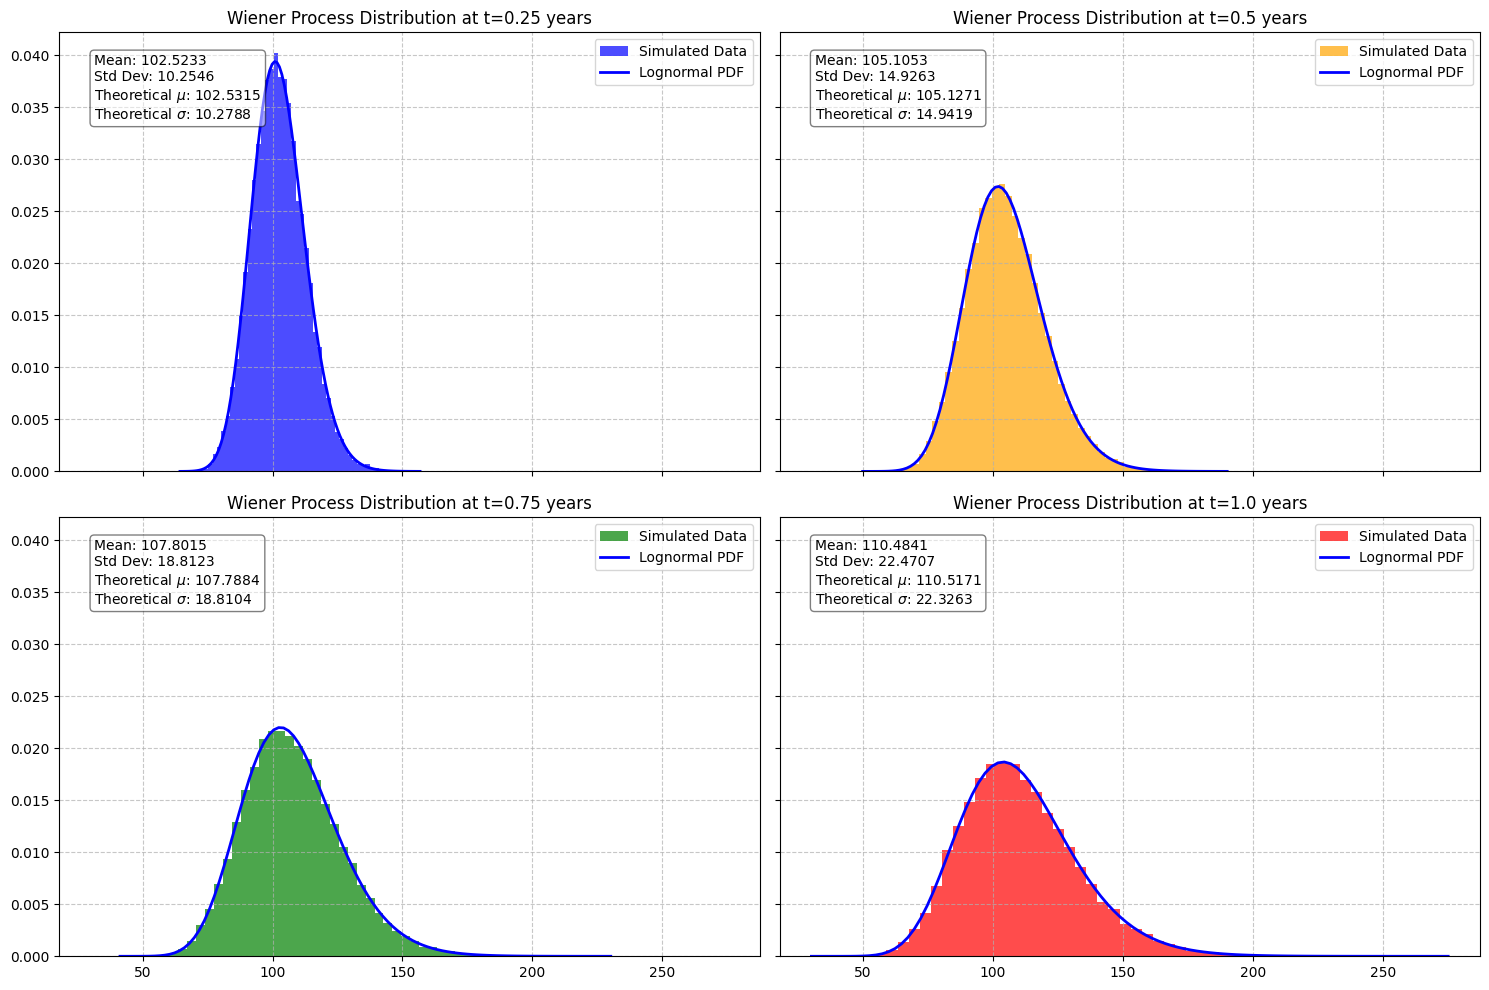

In [ ]:
indicies = [int(steps / 4), int(steps / 2), int(3 * steps / 4), steps]
titles = [f'Wiener Process Distribution at t={np.round(ind / trading_days_in_year, 2)} years' for ind in indicies]
colors = ['blue', 'orange', 'green', 'red']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    idx = indicies[i]
    data = paths.T[idx, :]
        
    ax.hist(data, bins=50, color=colors[i], alpha=0.7, density=True, label='Simulated Data')

    # A critical detail when using scipy.stats.lognorm is its parametrization: 
    # Shape parameter: This corresponds to the standard deviation sigma of the logarithm
    # Scale parameter: This corresponds to exp(mu), where mu is the mean of the logarithm.
    dist_mu = np.log(paths.T[idx, :]).mean()  # TODO: more info regarding lognormal distribution
    dist_sigma = np.log(paths.T[idx, :]).std()

    dist = lognorm(s=dist_sigma, scale=np.exp(dist_mu))
    x_range = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
    pdf = dist.pdf(x_range)

    ax.plot(x_range, pdf, 'b-', lw=2, label='Lognormal PDF')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    t_period = idx / trading_days_in_year
        
    stats_text = (f'Mean: {data.mean():.4f}\n'
                  f'Std Dev: {data.std():.4f}\n'
                  f'Theoretical $\mu$: {(s0 * np.exp(r * t_period)):.4f}\n'
                  f'Theoretical $\sigma$: {np.sqrt(s0**2 * np.exp(2*r*t_period) * (np.exp(sigma**2*t_period) - 1)):.4f}')  # TODO: more relevant info
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    ax.set_title(titles[i])
    ax.legend()

plt.tight_layout()
plt.plot()

In [9]:
# Parameters of normal distribution for logarithm of prices, TODO: check if correct
norm_mu = sigma ** 2 * ( (steps / 4) / trading_days_in_year )
norm_sigma = np.log(s0) + (r - (sigma**2 / 2)) * np.round((steps / 4) / trading_days_in_year, 2)
norm_mu, norm_sigma 

(0.010000000000000002, np.float64(4.625170185988091))

In [10]:
# TODO: compare with closed form solution of GBM